In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

In [2]:
# 1. 生成二维两类别数据集
n_samples = 100
# 设置两个类别中心，让它们有一些重叠
centers = [(-2, -2), (2, 2)]
X, y = make_blobs(n_samples=n_samples, centers=centers, random_state=42, cluster_std=1.5)

# 分离两个类别的数据
X_class0 = X[y == 0]
X_class1 = X[y == 1]

In [3]:
# 2. 实现 LDA 计算步骤

# 计算每个类别的均值向量
m0 = np.mean(X_class0, axis=0)
m1 = np.mean(X_class1, axis=0)

In [4]:
# 计算类内散度矩阵 (Sw)
# S_W = sum_{i=0}^1 sum_{x in C_i} (x - m_i)(x - m_i)^T
# 也可以用矩阵乘法：S_Wi = (X_i - m_i).T @ (X_i - m_i)
Sw0 = np.zeros((X.shape[1], X.shape[1]))
for x in X_class0:
    x_minus_m0 = (x - m0).reshape(-1, 1) # 转换为列向量
    Sw0 += x_minus_m0 @ x_minus_m0.T # 外积

Sw1 = np.zeros((X.shape[1], X.shape[1]))
for x in X_class1:
    x_minus_m1 = (x - m1).reshape(-1, 1)
    Sw1 += x_minus_m1 @ x_minus_m1.T

Sw = Sw0 + Sw1

In [5]:
# 计算类间散度矩阵 (Sb)
# S_B = (m0 - m1)(m0 - m1)^T
m0_minus_m1 = (m0 - m1).reshape(-1, 1)
Sb = m0_minus_m1 @ m0_minus_m1.T

In [6]:
# 3. 计算最优投影向量 w
# w ∝ Sw_inv @ (m0 - m1)
# 需要确保 Sw 是可逆的
try:
    Sw_inv = np.linalg.inv(Sw)
    w = Sw_inv @ (m0 - m1)
    # 归一化w（可选，不影响投影方向）
    w = w / np.linalg.norm(w) if np.linalg.norm(w) != 0 else w

except np.linalg.LinAlgError:
    print("警告：类内散度矩阵不可逆。可能因为数据维度过高或样本过少。无法计算 w。")
    w = None # 设置w为None，后续不进行投影和可视化


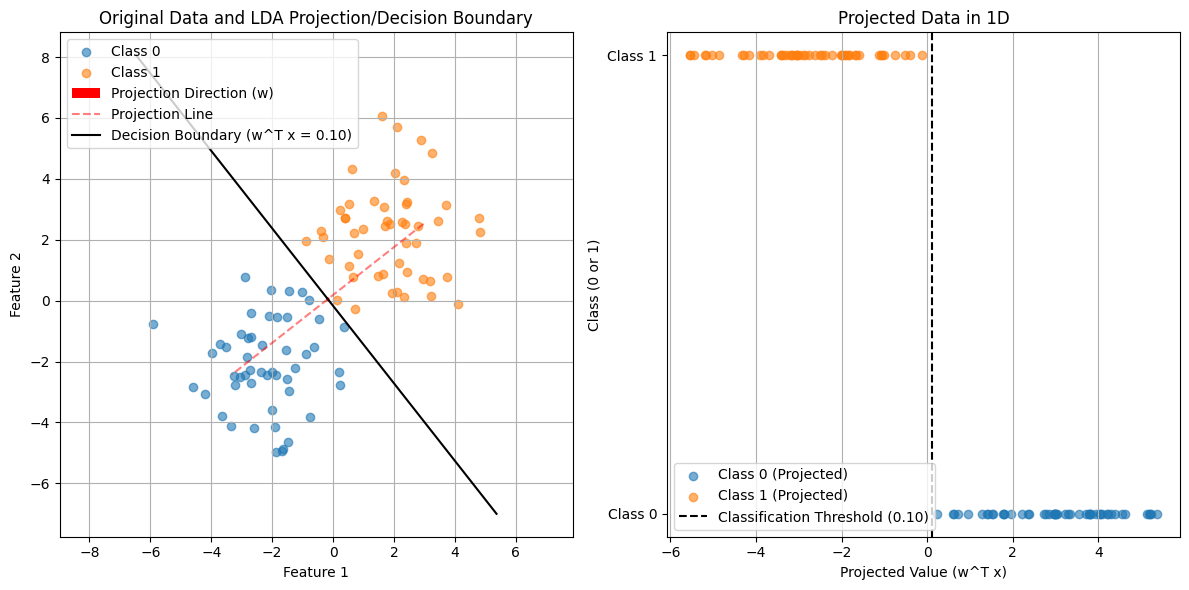

In [7]:
# 4. 将数据投影到 w 向量决定的直线上
if w is not None:
    # 投影 y = w^T @ x
    # 对于整个数据集 X，投影结果 Y = X @ w
    Y = X @ w

    # 5. 找到分类阈值
    # 简单起见，我们可以使用投影后两个类别均值的中点作为阈值
    projected_m0 = m0 @ w
    projected_m1 = m1 @ w
    threshold = (projected_m0 + projected_m1) / 2

    # 6. 可视化结果

    # 可视化原始数据和投影方向、决策边界
    plt.figure(figsize=(12, 6))

    # 原始数据散点图
    plt.subplot(1, 2, 1)
    plt.scatter(X_class0[:, 0], X_class0[:, 1], label='Class 0', alpha=0.6)
    plt.scatter(X_class1[:, 0], X_class1[:, 1], label='Class 1', alpha=0.6)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Original Data and LDA Projection/Decision Boundary')
    plt.grid(True)
    plt.axis('equal') # 保持x和y轴比例一致

    # 绘制投影方向向量 w
    # 为了看得清楚，可以从数据中心或原点出发，乘以一个缩放因子
    data_center = np.mean(X, axis=0)
    # 绘制从中心出发的向量
    plt.quiver(*data_center, w[0], w[1], scale=10, color='red', label='Projection Direction (w)', angles='xy', scale_units='xy')
    # 绘制一条表示投影直线的线（通过数据中心，方向是w）
    # 这条线方向是w，通过点data_center。线的方程可以参数化表示为 data_center + t*w
    # 我们找线上两个点来画线
    line_start = data_center - w * 4 # 4是一个缩放因子，让线穿过数据区域
    line_end = data_center + w * 4
    plt.plot([line_start[0], line_end[0]], [line_start[1], line_end[1]], 'r--', label='Projection Line', alpha=0.5)


    # 绘制决策边界
    # 决策边界是 w^T @ x = threshold
    # 在2D空间 (x, y) 中就是 w[0]*x + w[1]*y = threshold
    # 这是一条垂直于 w 的直线
    # 如果 w[1] != 0, y = (threshold - w[0]*x) / w[1]
    # 如果 w[1] == 0, x = threshold / w[0] (垂直线)
    if w[1] != 0:
        x_vals = np.array(plt.gca().get_xlim()) # 获取当前x轴的显示范围
        y_vals = (threshold - w[0] * x_vals) / w[1]
        plt.plot(x_vals, y_vals, 'k-', label=f'Decision Boundary (w^T x = {threshold:.2f})')
    elif w[0] != 0:
         # 垂直线
         y_vals = np.array(plt.gca().get_ylim()) # 获取当前y轴的显示范围
         x_vals = np.full_like(y_vals, threshold / w[0]) # x值固定
         plt.plot(x_vals, y_vals, 'k-', label=f'Decision Boundary (x = {threshold/w[0]:.2f})')
    else:
        print("警告：w向量为零向量，无法绘制决策边界。")


    plt.legend()


    # 可视化投影后的一维数据
    plt.subplot(1, 2, 2)
    # 将两类投影点分别绘制在Y轴的0或1位置，方便区分
    plt.scatter(Y[y == 0], np.zeros_like(Y[y == 0]), label='Class 0 (Projected)', alpha=0.6)
    plt.scatter(Y[y == 1], np.ones_like(Y[y == 1]), label='Class 1 (Projected)', alpha=0.6) # 将Class 1的点绘制在Y=1处
    # 绘制阈值线
    plt.axvline(x=threshold, color='k', linestyle='--', label=f'Classification Threshold ({threshold:.2f})')

    plt.xlabel('Projected Value (w^T x)')
    plt.ylabel('Class (0 or 1)')
    plt.title('Projected Data in 1D')
    plt.yticks([0, 1], ['Class 0', 'Class 1']) # 设置Y轴刻度标签
    plt.grid(True, axis='x') # 只绘制垂直网格线
    plt.legend()

    plt.tight_layout() # 调整布局，避免重叠
    plt.show()

else:
    print("由于w无法计算，跳过可视化步骤。")